3D slicc preprocessing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from dipy.io.image import load_nifti
import pandas as pd
import sklearn.cluster
import skimage.segmentation
#from fast_slic import Slic
from skimage.segmentation import mark_boundaries
from skimage.color import gray2rgb

In [2]:
def evaluate_segmentation(seg_hat_flat, seg_flat, tumor_label):
    #coordinates of predicted and actual tumor
    y_coors = np.argwhere(seg_flat!=0)

    yhat_coors = np.argwhere(seg_hat_flat ==tumor_label)

    #size of tumor and non-tumor (number of voxels)
    tumor_size=len(y_coors)
    total_size = len(seg_flat)
    non_tumor_size = total_size-tumor_size


    #true positive
    correct_id_tumor = np.intersect1d(y_coors, yhat_coors)

    
    
    percent_tumor_correct = len(correct_id_tumor)/tumor_size

    #false positive
    false_positive_points = np.setdiff1d(yhat_coors, y_coors)
    false_positive = len(false_positive_points)/non_tumor_size

    #false negative
    false_neg_points = np.setdiff1d(y_coors, yhat_coors)
    false_neg = len(false_neg_points)/tumor_size

    
    #true negative
    true_negative=(total_size-(tumor_size+len(false_positive_points)))/non_tumor_size

    #Total error (misidentification
    total_incorrect_points = np.concatenate((false_neg_points, false_positive_points))
    total_error = len(total_incorrect_points)/total_size
    
    print("True Positive: ", percent_tumor_correct)
    print("False negative: ", false_neg)
    print("True Negative: ", true_negative)
    print("False Positive: ", false_positive)
    
    print("************")
    print("Total Error: ", total_error)

# Replicate example from docs
https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_mask_slic.html#sphx-glr-auto-examples-segmentation-plot-mask-slic-py


In [3]:
from skimage import data
img = data.immunohistochemistry()
img.shape



(512, 512, 3)

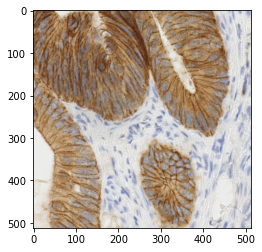

In [4]:
plt.figure()
plt.imshow(img)
plt.show()

In [5]:
slic = skimage.segmentation.slic(img, n_segments=200, start_label=1)
slic.shape

(512, 512)

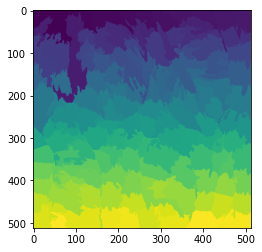

In [6]:
plt.figure()
plt.imshow(slic)
plt.show()

In [7]:
boundary_img = skimage.segmentation.mark_boundaries(img, slic)

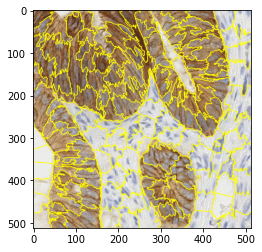

In [8]:
plt.figure()
plt.imshow(boundary_img)
plt.show()

# Load MRI data

In [9]:
sample_flair_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_flair.nii"
sample_seg_path = "../../lib/MICCAI_BraTS2020_TrainingData/BraTS20_Training_111/BraTS20_Training_111_seg.nii"


In [10]:
data_flair, affine, im = load_nifti(sample_flair_path, return_img=True)

In [11]:
data_seg, affine, im = load_nifti(sample_seg_path, return_img=True)

Basic preprocessing, need RGB for slicc to work

In [13]:
#FOR NOW, CAST AS ARRAY OF INTS (PROBABLY WANT FLOAT32 EVENTUALLY)
data_flair=data_flair/np.max(data_flair)

In [14]:
#convert to rGB color space
flair_rgb = gray2rgb(data_flair)
flair_rgb.shape

(240, 240, 155, 3)

#### Segment 2D slice using superpixels

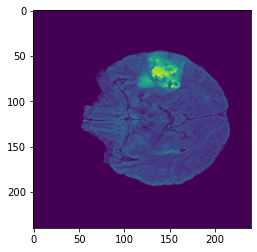

In [15]:
plt.figure()
plt.imshow(flair_rgb[:,:,60,0])
plt.show()

In [16]:
test_2d = flair_rgb[:,:,60,:]
test_2d.shape

(240, 240, 3)

In [57]:
n_segments_2d = 300
slic_2d = skimage.segmentation.slic(test_2d, n_segments=n_segments_2d, start_label=1)
slic_2d.shape

(240, 240)

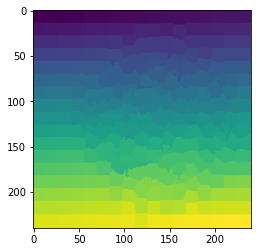

In [58]:
plt.figure()
plt.imshow(slic_2d)
plt.show()

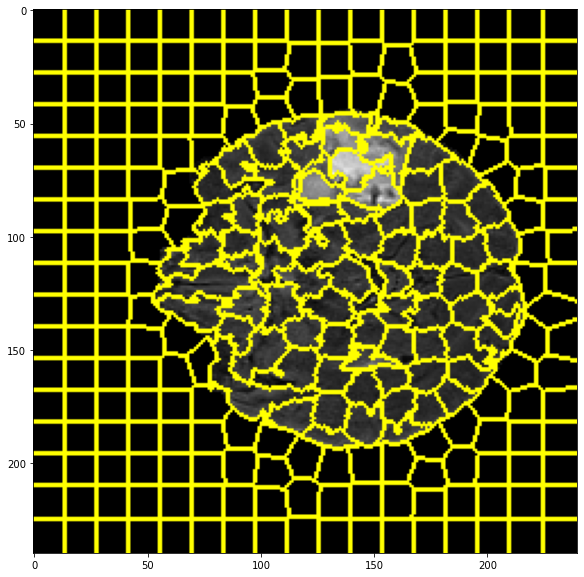

In [59]:
boundary_img = skimage.segmentation.mark_boundaries(test_2d, slic_2d)
plt.figure(figsize=(10,10))
plt.imshow(boundary_img)
plt.show()

#### Can we find a threshold that divides tumor from nontumor?

In [60]:
from skimage.color import rgb2gray
test_2d_gray = rgb2gray(test_2d)

In [61]:
test_2d_gray.shape

(240, 240)

In [62]:
slic_2d.shape

(240, 240)

Go through each label in slic segmentation, cluster image

In [63]:
labels2D = np.unique(slic_2d)
labels2D

array([  1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,
        92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117,
       118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130,
       131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143,
       144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156,
       157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169,
       170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 18

In [64]:
slic_cluster_2d =test_2d_gray.copy()
for label in labels2D:
    slic_cluster_2d[slic_2d==label]=np.average(slic_cluster_2d[slic_2d==label])

    

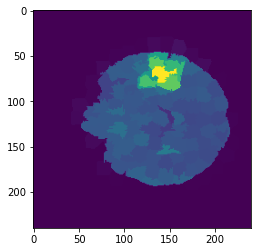

In [65]:
plt.figure()
plt.imshow(slic_cluster_2d)
plt.show()

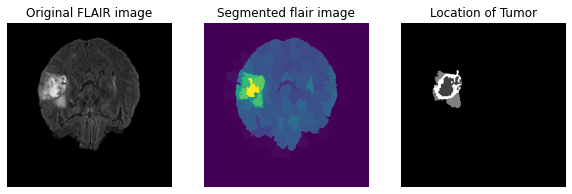

In [66]:

plt.figure(figsize=(10,5))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(slic_cluster_2d.T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(data_seg[:,:,60].T, cmap="gray", origin='lower')
plt.show()

Look at histogram , high values sparse

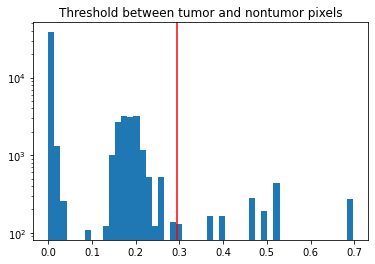

In [85]:

plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(slic_cluster_2d.flatten(), bins=50, log=True)
plt.axvline(x=0.295, color="red")
plt.show()

In [86]:
np.unique(slic_cluster_2d)

array([0.        , 0.00090373, 0.00097102, 0.00122562, 0.00139456,
       0.00142781, 0.00149585, 0.0022048 , 0.00255409, 0.00263117,
       0.00305363, 0.00307463, 0.00308945, 0.00359285, 0.00474029,
       0.00474905, 0.00518778, 0.00544106, 0.00763616, 0.00788752,
       0.00811801, 0.0087016 , 0.00967452, 0.0107248 , 0.01125025,
       0.01217537, 0.01600256, 0.01635081, 0.01655457, 0.01684728,
       0.01783579, 0.02029046, 0.03228618, 0.09732513, 0.12640165,
       0.14038153, 0.1407036 , 0.15077588, 0.15118476, 0.15234082,
       0.15351237, 0.15594696, 0.156517  , 0.15777414, 0.15790604,
       0.15822015, 0.15906391, 0.16044404, 0.16338837, 0.16381673,
       0.1648801 , 0.16568728, 0.1688575 , 0.16910355, 0.17019217,
       0.17219611, 0.17440881, 0.17468739, 0.17488505, 0.17617554,
       0.17775955, 0.1781409 , 0.17840767, 0.17987085, 0.18025304,
       0.18087177, 0.18100183, 0.18135018, 0.18190359, 0.1827107 ,
       0.18356802, 0.18391544, 0.18654519, 0.1873275 , 0.18884

In [87]:
seg_hat_2d = (slic_cluster_2d>0.295).astype(int)

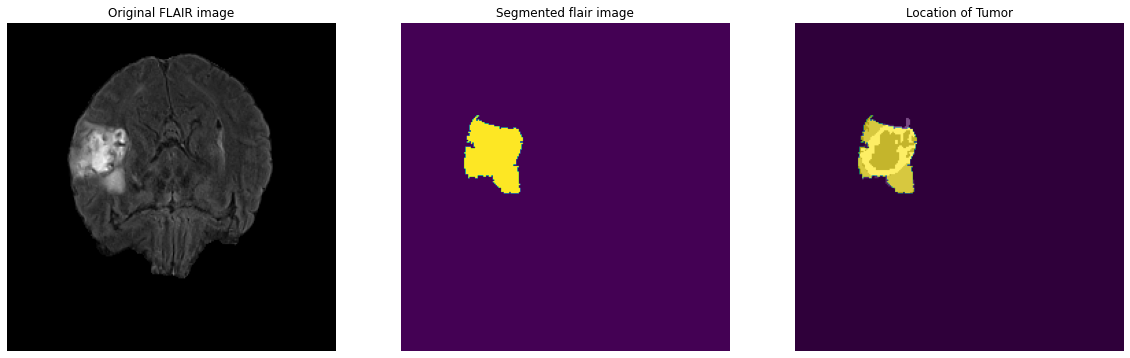

In [88]:

plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(seg_hat_2d.T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(seg_hat_2d.T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.3, cmap="gray", origin='lower')

plt.show()

In [89]:
np.unique(seg_hat_2d)

array([0, 1])

In [90]:
tumor_label = np.max(seg_hat_2d)
tumor_label

1

In [91]:
predicted = seg_hat_2d.flatten()
actual = (data_seg[:,:,60]).flatten()
evaluate_segmentation(predicted, actual, tumor_label)

True Positive:  0.9471471471471471
False negative:  0.05285285285285285
True Negative:  0.9988736926790024
False Positive:  0.0011263073209975866
************
Total Error:  0.0026215277777777777


# Segment whole MRI using superpixels

In [94]:
slic_3d = skimage.segmentation.slic(flair_rgb, n_segments=3000, start_label=1)

In [95]:
slic_3d.shape

(240, 240, 155)

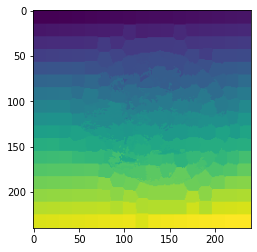

In [96]:
plt.figure()
plt.imshow(slic_3d[:,:,60])
plt.show()

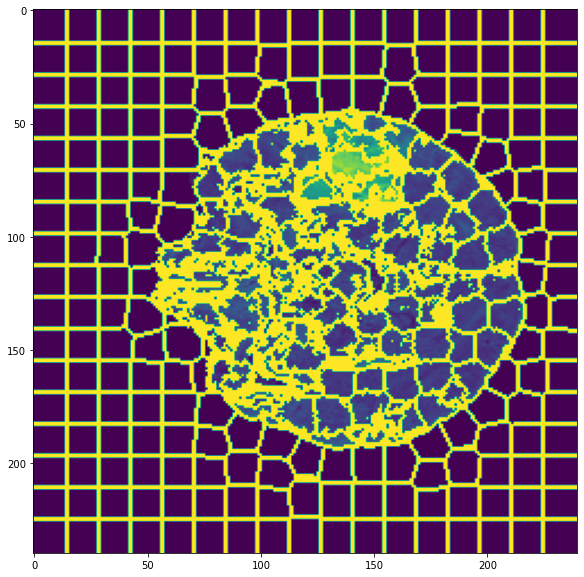

In [97]:
boundary_img = skimage.segmentation.mark_boundaries(flair_rgb, slic_3d)
plt.figure(figsize=(10,10))
plt.imshow(boundary_img[:,:,60,0])
plt.show()

#### Find discrimination boundary

In [98]:
from skimage.color import rgb2gray
slic_cluster_3d = rgb2gray(flair_rgb)

In [99]:
labels3D = np.unique(slic_3d)
labels3D

array([   1,    2,    3, ..., 3138, 3139, 3140])

In [100]:

for label in labels3D:
    slic_cluster_3d[slic_3d==label]=np.average(slic_cluster_3d[slic_3d==label])

    

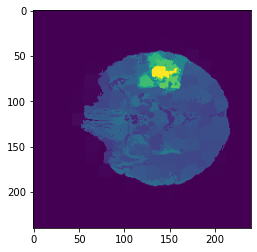

In [101]:
plt.figure()
plt.imshow(slic_cluster_3d[:,:,60])
plt.show()

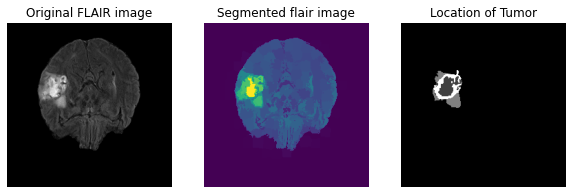

In [102]:

plt.figure(figsize=(10,5))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(slic_cluster_3d[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(data_seg[:,:,60].T, cmap="gray", origin='lower')
plt.show()

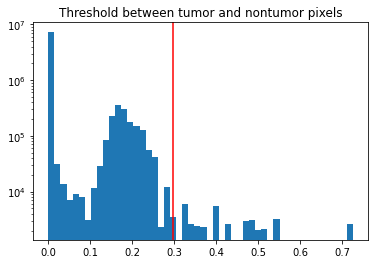

In [117]:

plt.figure()
plt.title("Threshold between tumor and nontumor pixels")
plt.hist(slic_cluster_3d.flatten(), bins=50, log=True)
plt.axvline(x=0.298, color="red")
plt.show()

In [118]:
np.unique(slic_cluster_3d)

array([0.00000000e+00, 1.48991033e-05, 2.35054915e-05, 2.62169181e-05,
       2.78812247e-05, 3.54247812e-05, 4.02678087e-05, 4.57658172e-05,
       5.33731473e-05, 5.70734171e-05, 7.22017405e-05, 8.13486503e-05,
       9.55692164e-05, 9.56358534e-05, 9.80269100e-05, 9.95431072e-05,
       1.05569415e-04, 1.64319785e-04, 1.64574940e-04, 1.68868157e-04,
       1.70931072e-04, 1.71517727e-04, 1.96922916e-04, 2.05646850e-04,
       2.12590969e-04, 2.43624175e-04, 2.53161975e-04, 2.68184495e-04,
       2.68570762e-04, 2.84946518e-04, 2.96829378e-04, 3.29567102e-04,
       3.44278383e-04, 3.45036232e-04, 3.49477494e-04, 3.59312093e-04,
       3.96130345e-04, 4.00948094e-04, 4.03152894e-04, 4.11226877e-04,
       4.40144467e-04, 4.42048178e-04, 4.51441143e-04, 4.55169830e-04,
       4.58350595e-04, 4.72529271e-04, 4.86340763e-04, 4.93186564e-04,
       5.05474394e-04, 5.15804490e-04, 5.40359292e-04, 5.46371809e-04,
       5.59119955e-04, 5.92184913e-04, 5.98111350e-04, 7.04713319e-04,
      

In [121]:
seg_hat_3d = (slic_cluster_3d >0.298).astype(int)

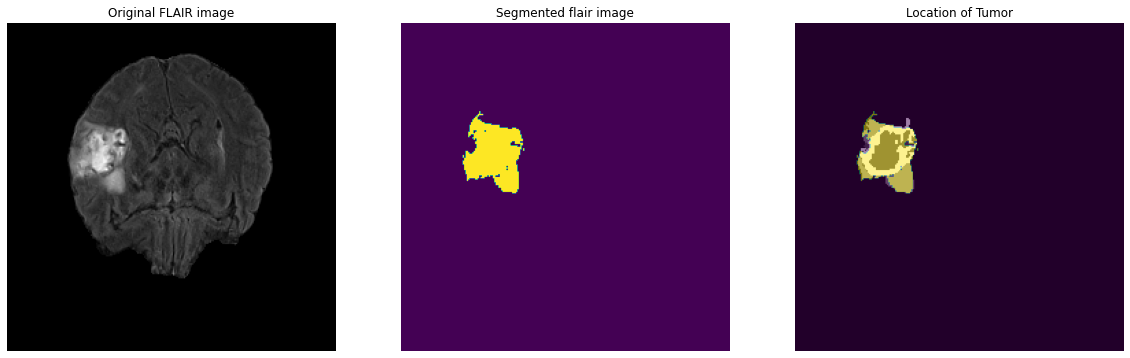

In [122]:

plt.figure(figsize=(20,10))

plt.subplot(1,3,1).set_axis_off()
plt.title("Original FLAIR image")
plt.imshow(data_flair[:,:,60].T, cmap="gray", origin='lower')

plt.subplot(1,3,2).set_axis_off()
plt.title("Segmented flair image")
plt.imshow(seg_hat_3d[:,:,60].T,  origin='lower')

plt.subplot(1,3,3).set_axis_off()
plt.title("Location of Tumor")

plt.imshow(seg_hat_3d[:,:,60].T, origin='lower')
plt.imshow(data_seg[:,:,60].T, alpha = 0.5, cmap="gray", origin='lower')

plt.show()

In [123]:
tumor_label = np.max(seg_hat_3d)
tumor_label

1

In [124]:

evaluate_segmentation(seg_hat_3d.flatten(), data_seg.flatten(), tumor_label)

True Positive:  0.8082691154076876
False negative:  0.1917308845923123
True Negative:  0.9996891270322392
False Positive:  0.00031087296776083
************
Total Error:  0.0012401433691756273
